# Hedging Using Derivatives.
<p>Potential use of this analysis could be to assist  utility producers to hedge their winter electricity demand volume risk. Which is very variable.</p>


In [21]:
# Libraries we use 
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(quantmod))
suppressPackageStartupMessages(library(data.table))

In [22]:
weather = fread("/Users/robertgitari/Desktop/Fuqua Academics/Term3/Derivatives/Assignments/Team /1/weather_data.csv")
head(weather)
summary(weather)
df = weather

StateCode,Division,YearMonth,PCP,TAVG,PDSI,PHDI,ZNDX,PMDI,CDD,HDD,SP01,SP02,SP03,SP06,SP09,SP12,SP24,TMIN,TMAX
45,0,189511,3.35,35.5,-2.59,-2.59,-2.52,-2.59,0,749,-1.13,-1.79,-1.53,-1.93,-1.77,-99.99,-99.99,27.8,43.2
45,0,189512,9.09,31.0,0.83,-1.49,2.49,-0.37,0,874,1.15,-0.06,-0.94,-1.02,-0.95,-1.03,-99.99,25.3,36.7
45,0,189601,8.55,30.2,1.47,-0.61,2.19,1.41,0,898,1.12,1.41,0.49,-0.38,-0.46,-0.91,-99.99,24.1,36.4
45,0,189602,4.65,36.5,1.20,-0.66,-0.36,1.08,0,673,0.08,0.86,1.27,-0.19,-0.60,-0.58,-99.99,29.3,43.7
45,0,189603,2.86,36.4,0.58,-1.09,-1.48,0.05,0,777,-0.81,-0.43,0.33,-0.45,-0.55,-0.55,-99.99,26.5,46.2
45,0,189604,4.22,41.9,1.34,1.34,2.45,1.34,0,618,1.17,0.05,0.10,0.37,-0.29,-0.38,-99.99,32.0,51.8


   StateCode     Division   YearMonth           PCP              TAVG      
 Min.   :45   Min.   :0   Min.   :189511   Min.   : 0.030   Min.   :12.70  
 1st Qu.:45   1st Qu.:0   1st Qu.:192610   1st Qu.: 1.550   1st Qu.:35.40  
 Median :45   Median :0   Median :195710   Median : 2.980   Median :46.10  
 Mean   :45   Mean   :0   Mean   :195732   Mean   : 3.526   Mean   :46.29  
 3rd Qu.:45   3rd Qu.:0   3rd Qu.:198809   3rd Qu.: 5.060   3rd Qu.:57.38  
 Max.   :45   Max.   :0   Max.   :201908   Max.   :16.610   Max.   :69.40  
      PDSI               PHDI              ZNDX               PMDI        
 Min.   :-5.10000   Min.   :-5.1000   Min.   :-5.00000   Min.   :-5.1000  
 1st Qu.:-1.52000   1st Qu.:-1.7400   1st Qu.:-1.30750   1st Qu.:-1.5275  
 Median :-0.07000   Median :-0.6200   Median :-0.15000   Median :-0.0900  
 Mean   :-0.09328   Mean   :-0.1257   Mean   :-0.04114   Mean   :-0.1105  
 3rd Qu.: 1.34750   3rd Qu.: 1.5675   3rd Qu.: 1.11000   3rd Qu.: 1.2300  
 Max.   : 5.85000 

In [23]:
#create a vector that stores the sum of winter HDD in each year 
a <- vector()
starty <- 2018
endy <- 1895
years <- starty-endy +1 

for (i in 1:years) { 
  a[i] <- sum(df[(i*12-11):(i*12-7), 'HDD'])
}
HDD_winter <- a
year <- seq(1895,2018,1) 

## We can see that the HDD is very volatile across the past 140 years 

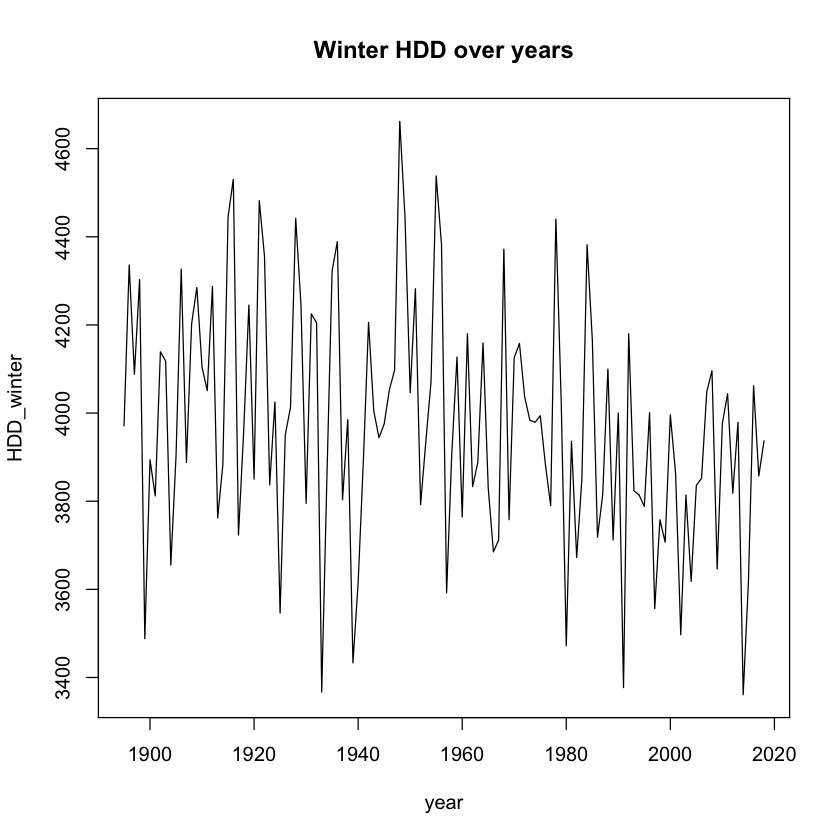

In [24]:
plot(year, HDD_winter, type='l', main ='Winter HDD over years') 

In [25]:
# building up the model 
lm0 <- lm(HDD_winter ~ year)
summary(lm0)

#detrend the residual 
residual <- HDD_winter - lm0$fitted.values 
std_noise <- sd(residual) 


Call:
lm(formula = HDD_winter ~ year)

Residuals:
    Min      1Q  Median      3Q     Max 
-655.80 -186.56  -15.54  193.34  672.03 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 8253.5518  1279.9705   6.448 2.38e-09 ***
year          -2.1887     0.6541  -3.346  0.00109 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 260.7 on 122 degrees of freedom
Multiple R-squared:  0.08406,	Adjusted R-squared:  0.07655 
F-statistic:  11.2 on 1 and 122 DF,  p-value: 0.00109


## Simulate HDD of the coming winter
<p> We want to model the dynamic process of “HDD_winter” so that we can evaluate the derivatives contracts. We do this by simulating HDD winter.<p>

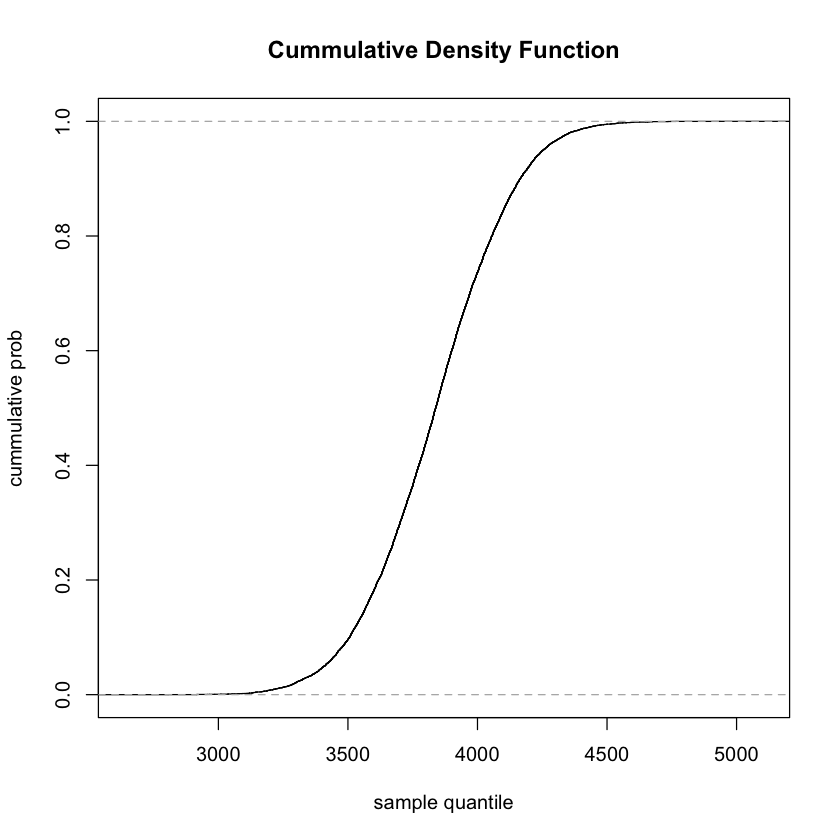

In [26]:
set.seed(1230)
scores <- rnorm(10000, 0, std_noise) 
scores <- scores + summary(lm0)$coefficients[2,1]* 2019 + summary(lm0)$coefficients[1,1]


empDensityFunc <- ecdf(scores)
plot(empDensityFunc, xlab = 'sample quantile', ylab='cummulative prob', main='Cummulative Density Function')

#Payoff fo Basic Floor 
payoff_Basic <- vector()
for (i in 1:10000) { 
  if ( scores[i] < 4200 ){ 
     payoff_Basic[i] <- min((4200 - scores[i]) * 15000, 9000000) 
  } else {
    payoff_Basic[i] <- 0
  }
} 

#Payoff to Reduced Tick Size 
payoff_Reduced <- vector() 
for (i in 1:10000) { 
  if ( scores[i] < 4200 ){
    payoff_Reduced[i] <- min((4200 - scores[i]) * 10000, 8000000) 
  } else {
    payoff_Reduced[i] <- 0
  }
}

#Payoff to Lower Stike 
payoff_Lower <- vector() 
for (i in 1:10000) { 
  if ( scores[i] < 3900 ){
    payoff_Lower[i] <- min((3900 - scores[i]) * 15000, 7000000) 
  } else {
    payoff_Lower[i] <- 0
  }
}

In [27]:
premium_basic <- 5500000
premium_reduced <- 4000000
premium_lower <- 2500000

profit_basic <- payoff_Basic - premium_basic
profit_reduced <- payoff_Reduced - premium_reduced
profit_lower<- payoff_Lower - premium_lower

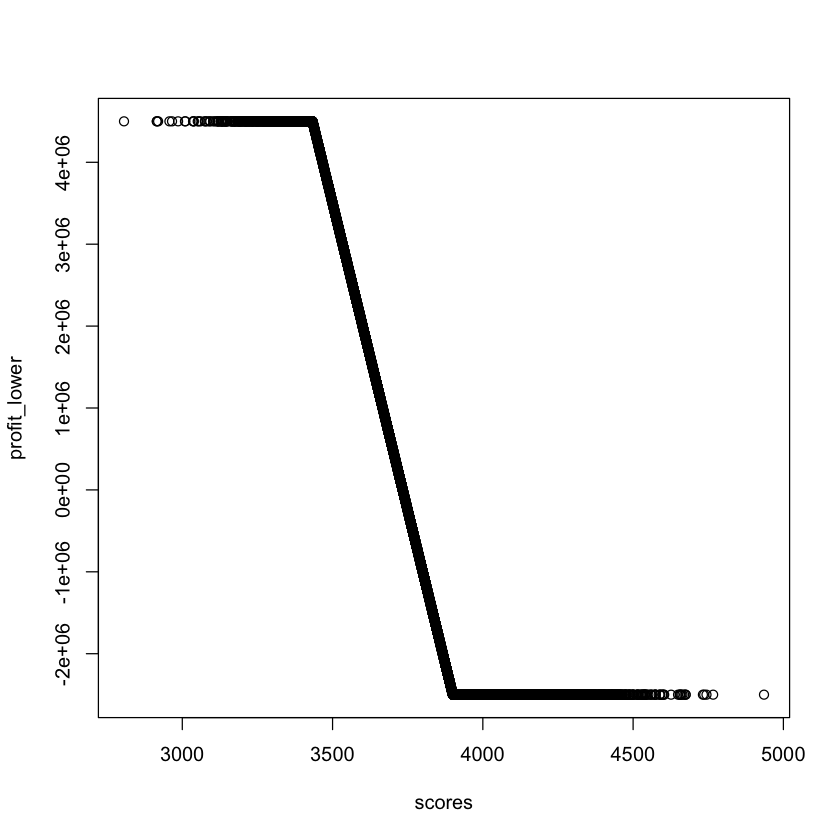

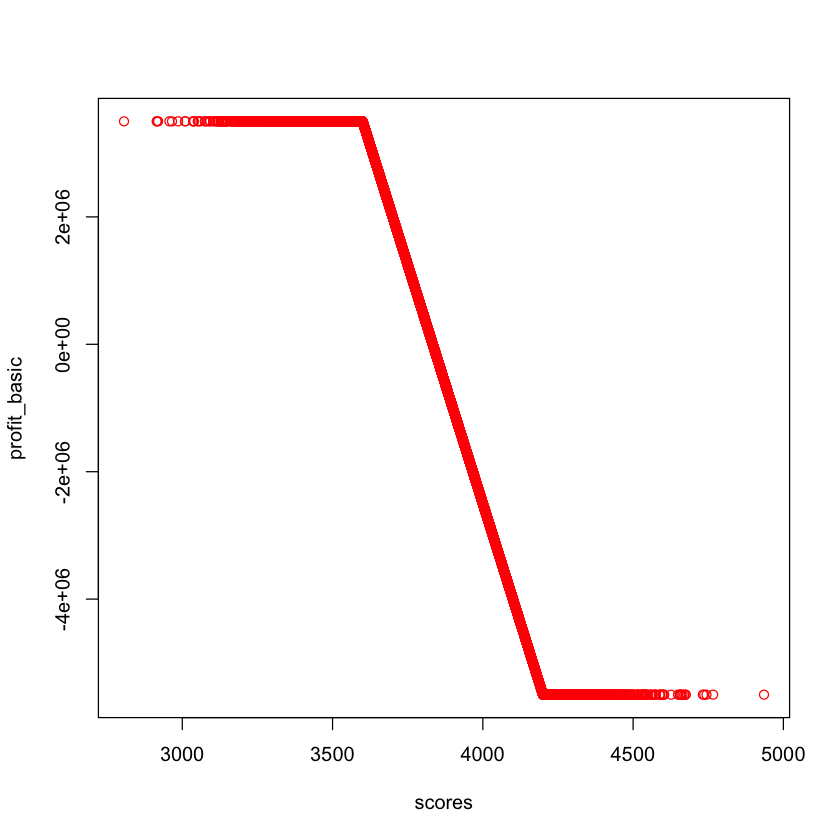

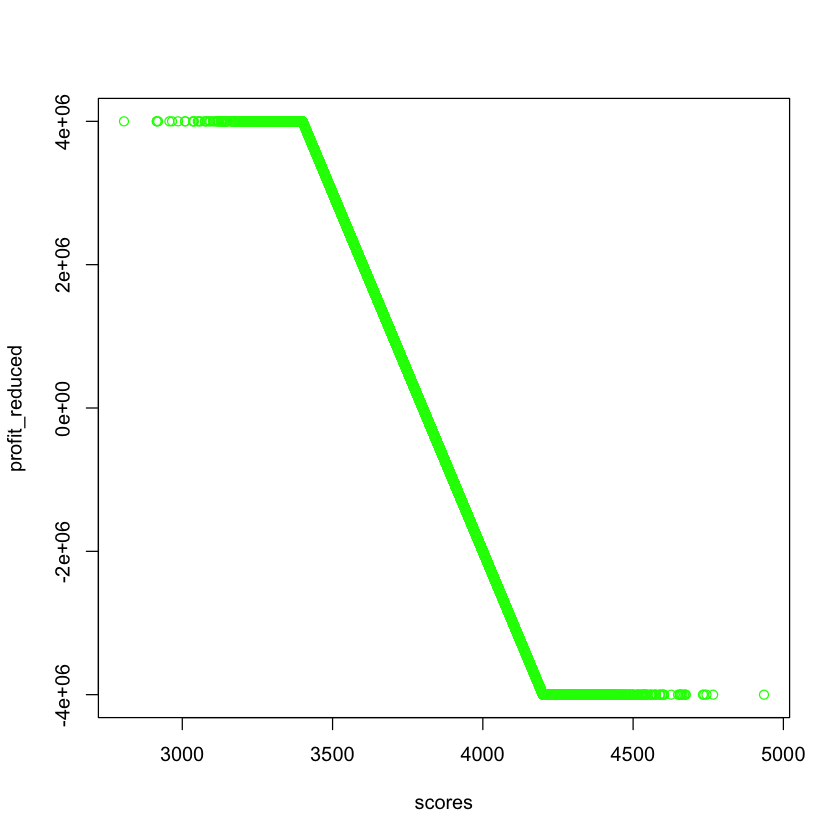

In [28]:
plot(scores ,profit_lower,col="black")
plot(scores ,profit_basic,col="red")
plot(scores ,profit_reduced,col="green")

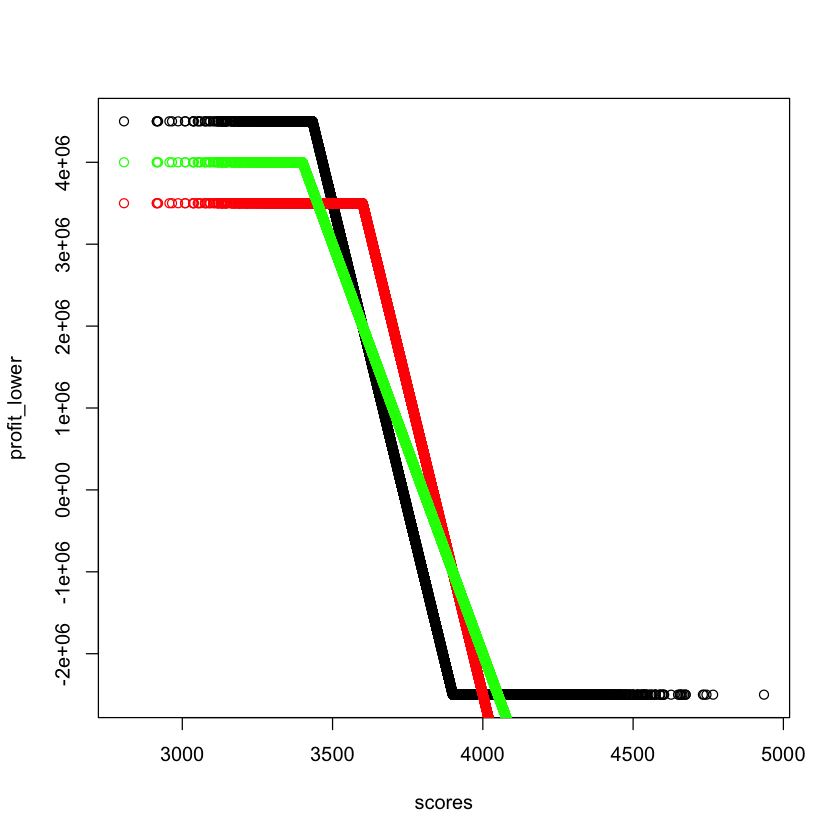

In [29]:
plot(scores ,profit_lower,col="black")
points(scores ,profit_basic,col="red")
points(scores ,profit_reduced,col="green")

## Conclusion/Summary
</p> All three contracts could help hedge certain downside risk when the HDD is not very low. However,
there are some differences among those contracts. </p>

</p> From the graph of profit for each of three contracts, we can see that Lower Contract (in black)  would be optimal if one believes that the future winter HDD would be very low (thus hedging against extreme downside risk). On the contrary, the Basic Contract (in red)  and Reduced Contract (in green) each hedges against certain ranges of HDD, where Basic Contract is optimal when HDD is expected to fall into the range between about 3600 to 3800 while Reduced Contract is optimal when HDD is expected to be in the range between about 3800 to 4050.</p> 